<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/Stable_Diffusion_v1_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Follow the instruction: https://tree.rocks/make-diffusion-model-from-scratch-easy-way-to-implement-quick-diffusion-model-e60d18fd0f2e

TODO

- gpu

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import re

from typing import Dict, List

import numpy as np

!pip install tqdm
from tqdm.auto import trange, tqdm

In [ ]:
USE_GPU = True

# number of workers in .map() call
# good number to use is ~order number of cpu cores // 2
#
# However, use 24 causes the Dataloader to fail.
NUM_PROC = 2

In [ ]:
BATCH_SIZE = 128  # for training batch size
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32

In [ ]:
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  assert device.type != 'cpu', "GPU is not available"
else:
  device = 'cpu'

print(device)

cuda:0


# Load dataset

- CIFAR-10

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# The ordering of labels is:

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def _get_car_subset(ds: torch.utils.data.Dataset) -> torch.utils.data.Dataset:
  """
  Extract the sub dataset containing the image corresponding to label 'car'.
  """
  idx = [i for i, (image, label) in enumerate(ds) if label == 1]
  # print(f'{len(idx)=}')
  sub_ds = torch.utils.data.Subset(ds, idx)
  return sub_ds

In [ ]:
trainloader = torch.utils.data.DataLoader(_get_car_subset(trainset),
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_PROC)

testloader = torch.utils.data.DataLoader(_get_car_subset(testset),
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_PROC)

In [ ]:
print(f'train ds size = {len(trainloader)}, test_ds size = {len(testloader)}')

train ds size = 40, test_ds size = 8


In [ ]:
# Prepare CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# filter training imgs
idx = [i for i, (img, label) in enumerate(all_trainset) if label == 1]
sub_trainset = torch.utils.data.Subset(all_trainset, idx)

trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


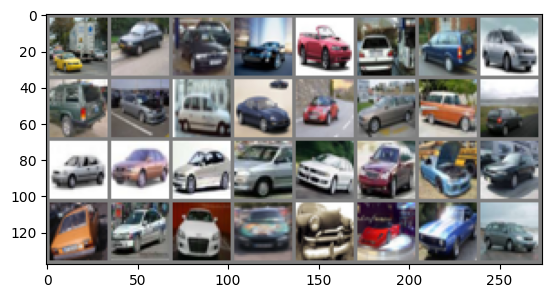

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:32]))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))


# Function for preview data

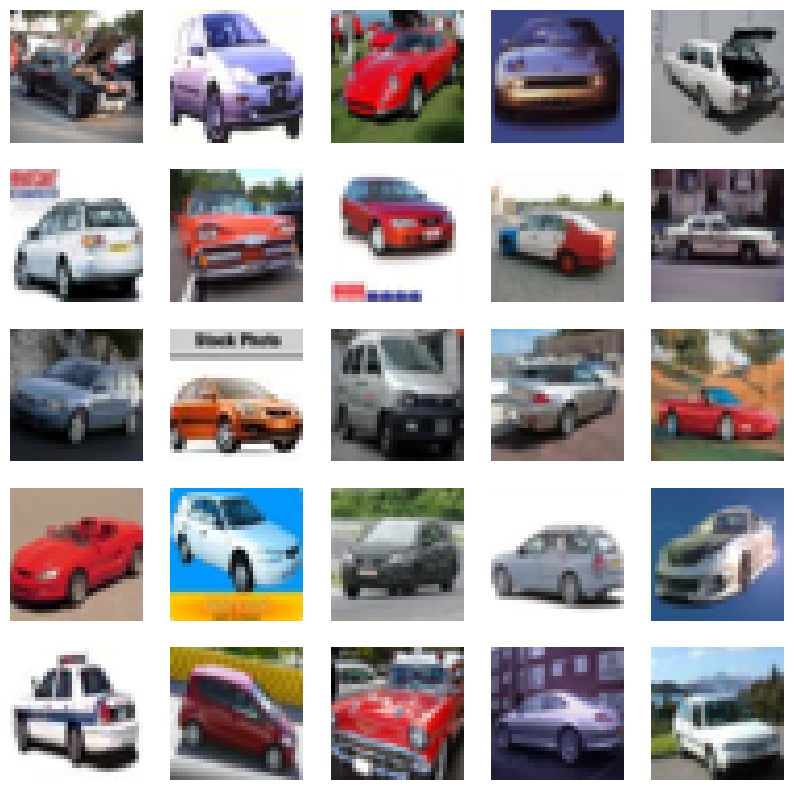

In [ ]:
def cvtImg(img: torch.Tensor) -> List:
  """Convert the image to be used in `imshow`.

  The image in data has float in range [-1, 1].

  Convert it to [0, 1] range.

  Args
    img: (B, C, W, T)

  Return
    A list with B size, containing Tensors of shape (C, W, T).
  """
  img = img.permute(0, 2, 3, 1)   # (B, 3, 32, 32) ---> (B, 32, 32, 3)
  img = img - img.min()
  img = (img / img.max())
  return img.cpu().numpy().astype(np.float32)

def show_examples(x: torch.Tensor):
  """Display 25 images.

  Args
    x: a batch of images. (B, C, W, H)
  """
  plt.figure(figsize=(10, 10))
  # x = torch.clamp(x, min=-1.0, max=1.0)
  imgs = cvtImg(x)
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')

images, _ = next(iter(trainloader))
show_examples(images)

# Noise

- timestamp 0: most noisy
- timestamp 16: most clear

In [ ]:
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1)

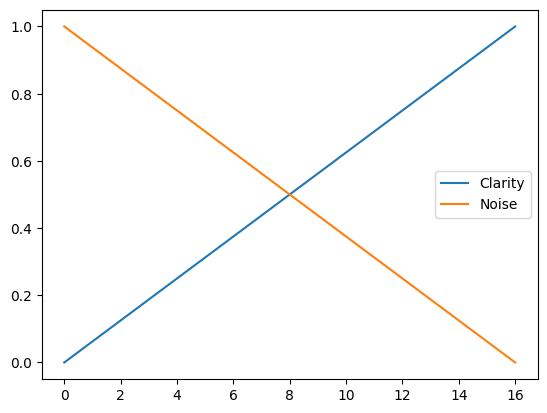

In [ ]:
plt.plot(1 - time_bar, label='Clarity')
plt.plot(time_bar, label='Noise')
plt.legend()

In [ ]:
def generate_ts(num: int) -> List[int]:
  """Generate random timesteps.

  Returns:
    The result contains `num` timesteps, each in range [0, timesteps 15).

  """
  return np.random.randint(0, timesteps, size=num)

def forward_noise(x: torch.Tensor, t: List[int]):
  """Add noise to images.

  For each image, it generates two images, the img_from is at the leading
  timestep, the img_to is at the next timestep.

  Note that x and t both have B as the leading dim; the x is noisified to mimic
  the noise at the leading and next timesteps at the corresponding indices of t.

  Args
    x: the images. (B, 3, 32, 32)
    t: a list of leading timesteps. (B)

  Return
    imgs_from: the noisified images to mimic the noise at the leading timesteps.
      (B, 3, 32, 32)
    imgs_to: the noisified images to mimic the noise at the next timestemps.
      (B, 3, 32, 32)
  """

  x = x.to(device)

  assert x.shape[0] == len(t)

  a = time_bar[t]       # (B)
  b = time_bar[t + 1]   # (B)
  # print(f'{a=}')
  # print(f'{b=}')

  noise = torch.normal(mean=torch.zeros_like(x),
                       std=torch.ones_like(x)).to(device)    # (3, 32, 32)
  a = torch.Tensor(a).view(-1, 1, 1, 1).to(device)        # (B, 1, 1, 1)
  b = torch.Tensor(b).view(-1, 1, 1, 1).to(device)        # (B, 1, 1, 1)
  # print(f'{a=}')
  # print(f'{b=}')

  # The clamps are needed because the added noise may get the pixel's value out
  # of [-1.0, 1.0]
  imgs_from = (1 - a) * x + a * noise                     # (B, 32, 32, 32)
  # imgs_from = torch.clamp(imgs_from, min=-1.0, max=1.0)

  imgs_to = (1 - b) * x + b * noise                       # (B, 32, 32, 32)
  # imgs_to = torch.clamp(imgs_to, min=-1.0, max=1.0)

  return imgs_from, imgs_to

t = generate_ts(25)
# Get a batch of images
x, _ = next(iter(trainloader))
imgs_from, imgs_to = forward_noise(x[:25], t)
print(f'{imgs_from.max()=}, {imgs_from.min()=}')

imgs_from.max()=tensor(3.6827, device='cuda:0'), imgs_from.min()=tensor(-3.7490, device='cuda:0')


In [ ]:
# The larger it is expected to be clearer
t

array([ 2,  3, 10, 12,  8,  3,  3,  5,  3, 10, 14, 12, 12,  0, 15,  5,  7,
        6,  9,  0,  3,  0, 13,  1,  8])

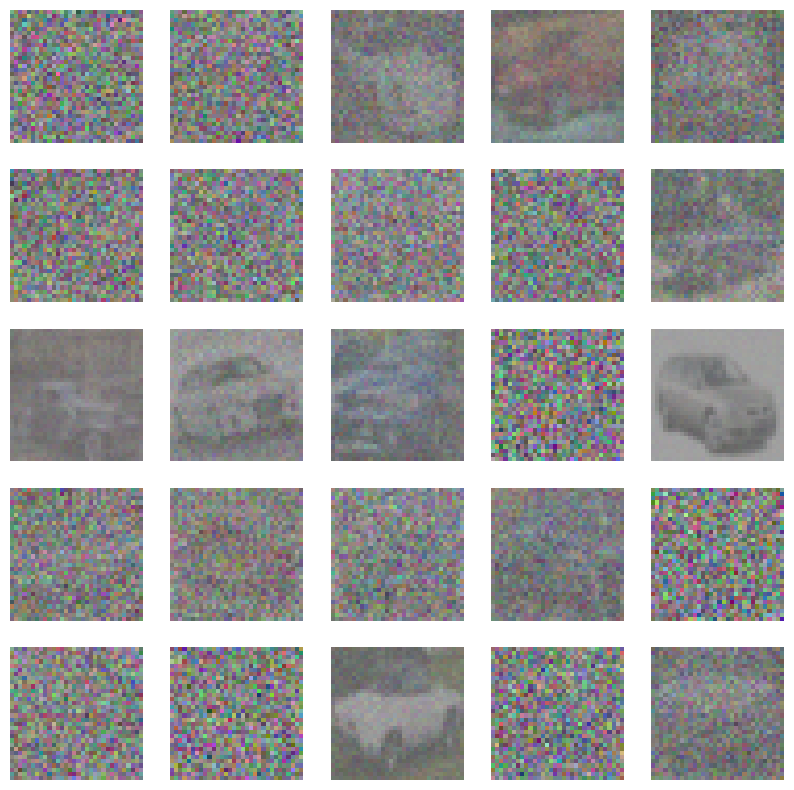

In [ ]:
show_examples(imgs_from)

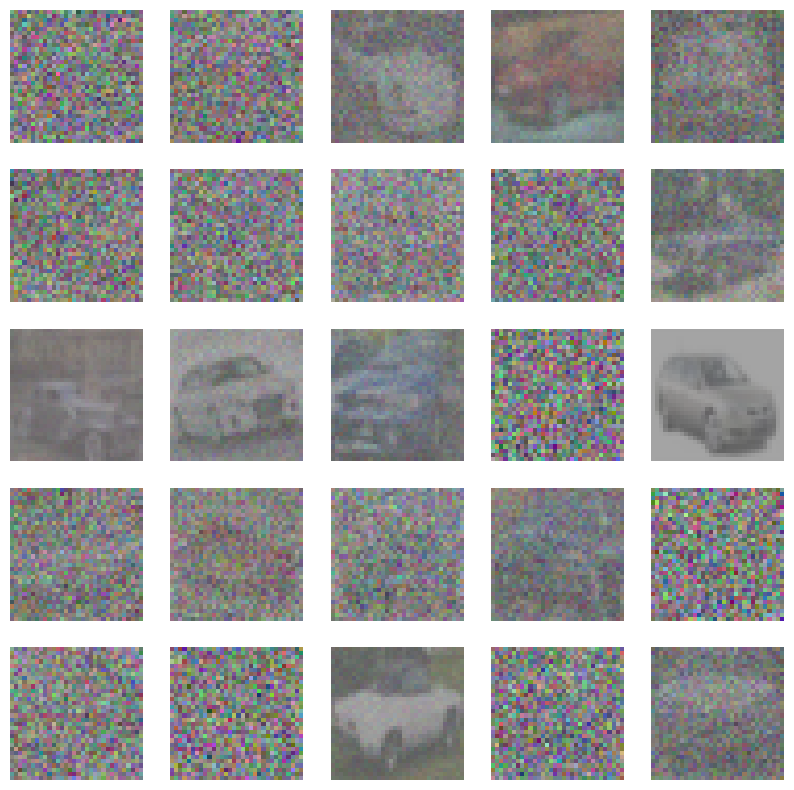

In [ ]:
show_examples(imgs_to)

# Model

## Block

Each block contains two CNN with a time parameter, allowing the network to determine its current time step and output corresponding information.

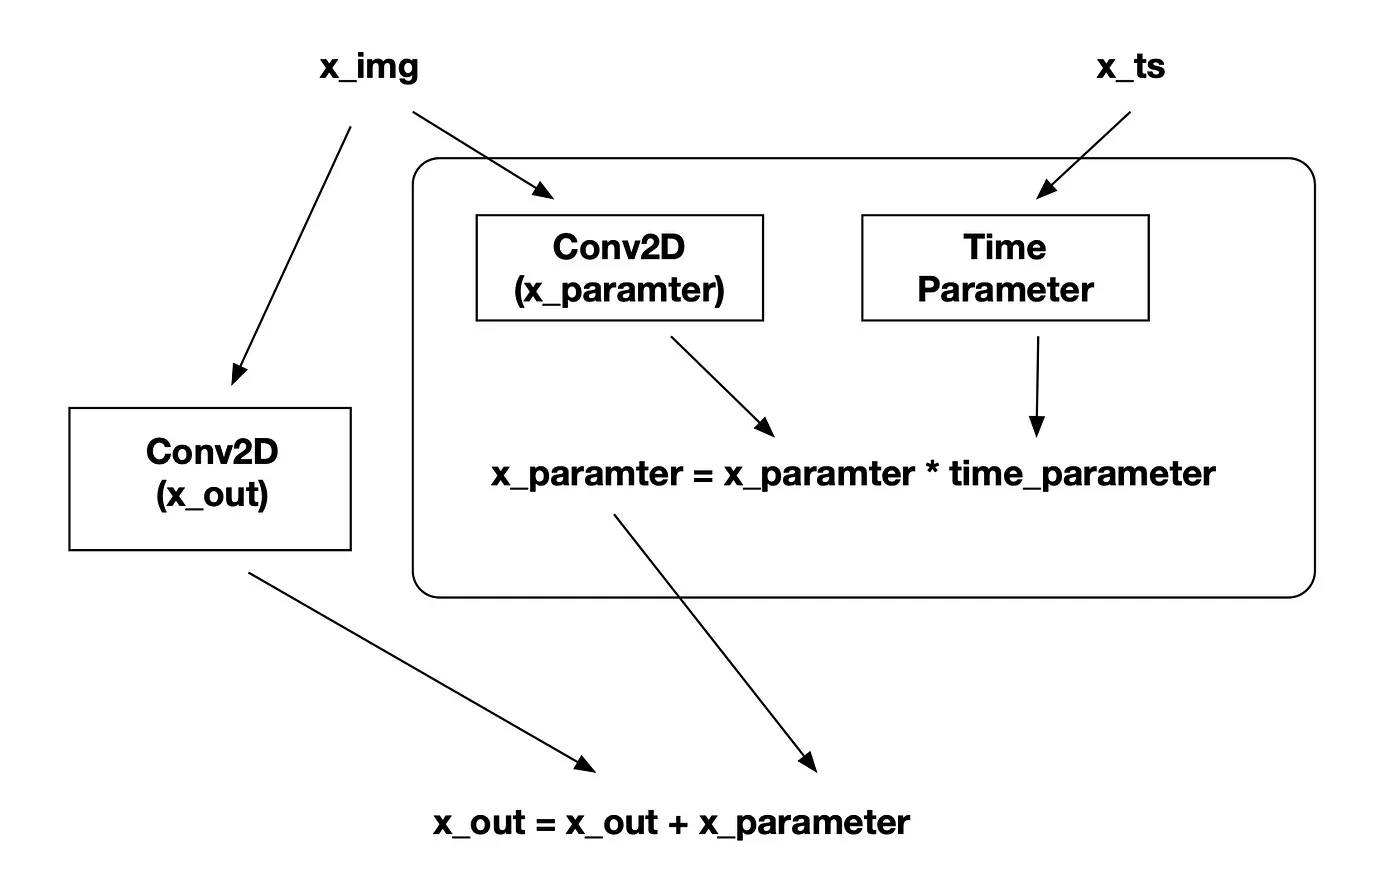

In [ ]:
class Block(torch.nn.Module):
  def __init__(self, in_channels: int, size: int):
    """
    Args
      in_channels: the # of input channels
      n_axis_pixels: the # of pixels on each axis
    """
    super().__init__()

    self.conv_x_param = torch.nn.Conv2d(in_channels=in_channels,
                                        out_channels=128,
                                        kernel_size=3,
                                        padding='same')
    self.conv_out = torch.nn.Conv2d(in_channels=in_channels,
                                        out_channels=128,
                                        kernel_size=3,
                                        padding='same')

    self.linear_ts_param = torch.nn.Linear(192, 128)
    self.relu_ts_param = torch.nn.ReLU()

    self.layer_norm = torch.nn.LayerNorm([128, size, size])

  def forward(self, x_img: torch.Tensor, x_ts: torch.Tensor):
    """
    Arg
      x_img: the image. (B, C, 32, 32)
      x_ts: the timestep encoding. (B, 192)
    """

    # print(f'{x_img.shape=}')
    x_param = F.relu(self.conv_x_param(x_img))    # (B, 128, 32, 32)
    # print(f'{x_param.shape=}')

    ts_param = self.relu_ts_param(self.linear_ts_param(x_ts)) # (B, 128)
    ts_param = ts_param.view(-1, 128, 1, 1)             # (B, 128, 1, 1)
    # print(f'{ts_param.shape=}')
    x_param = x_param * ts_param

    x_out = self.conv_out(x_img)            # (B, 128, size, size)
    x_out = x_out + x_param                 # (B, 128, size, size)
    x_out = F.relu(self.layer_norm(x_out))  # (B, 128, size, size)

    return x_out


block = Block(in_channels=3, size=32)
_ = block(x, torch.ones((BATCH_SIZE, 192,)))

## U-net

In [ ]:
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.down_x32 = Block(in_channels=3, size=32)
    self.down_x16 = Block(in_channels=128, size=16)
    self.down_x8 = Block(in_channels=128, size=8)
    self.down_x4 = Block(in_channels=128, size=4)

    self.up_x4 = Block(in_channels=128 + 32, size=4)
    self.up_x8 = Block(in_channels=256, size=8)
    self.up_x16 = Block(in_channels=256, size=16)
    self.up_x32 = Block(in_channels=256, size=32)

    ts_emb_dim = 192

    self.ts_emb = torch.nn.Linear(1, ts_emb_dim)

    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(128 * 4 * 4 + ts_emb_dim, 128),
        torch.nn.LayerNorm([128]),
        torch.nn.ReLU(),

        torch.nn.Linear(128, 32 * 4 * 4),
        torch.nn.LayerNorm([32 * 4 * 4]),
        torch.nn.ReLU(),
    )

    self.cnn_output = torch.nn.Conv2d(in_channels=128,
                                      out_channels=3,
                                      kernel_size=1,
                                      padding='same')

  def forward(self, x_img: torch.Tensor, x_ts: torch.Tensor):
    """
    Args
      x_img: (B, 3, 32, 32)
      x_ts: (B, 1)
    """

    y_ts = self.ts_emb(x_ts)    # (B, 192)

    y32 = self.down_x32(x_img, y_ts)    # (B, 128, 32, 32)

    y16 = F.max_pool2d(y32, 2)            # (B, 128, 16, 16)
    y16 = self.down_x16(y16, y_ts)        # (B, 128, 16, 16)

    y8 = F.max_pool2d(y16, 2)            # (B, 128, 8, 8)
    y8 = self.down_x8(y8, y_ts)         # (B, 128, 8, 8)
    # print(f'{y8.shape=}')

    y4 = F.max_pool2d(y8, 2)            # (B, 128, 4, 4)
    y4 = self.down_x4(y4, y_ts)         # (B, 128, 4, 4)
    # print(f'{y4.shape=}')

    y_mlp = y4.view(y4.shape[0], -1)                          # (B, 128*4*4=2048)
    y_mlp = torch.concat([y_mlp, y_ts], dim=1)                # (B, 2048+192=2240)
    y_mlp = self.mlp(y_mlp)                                   # (B, 512)
    y_mlp = y_mlp.view(y_mlp.shape[0], -1, y4.shape[-2], y4.shape[-1])  # (B, 32, 4, 4)
    # print(f'{y_mlp.shape=}')

    y4_up = self.up_x4(torch.cat([y4, y_mlp], dim=1), y_ts)   # (B, 128, 4, 4)

    y8_up = F.interpolate(y4_up, scale_factor=2, mode='bilinear')   # (B, 128, 8, 8)
    y8_up = self.up_x8(torch.cat([y8_up, y8], dim=1), y_ts)         # (B, 128, 8, 8)

    y16_up = F.interpolate(y8_up, scale_factor=2, mode='bilinear')    # (B, 128, 16, 16)
    y16_up = self.up_x16(torch.cat([y16_up, y16], dim=1), y_ts)       # (B, 128, 16, 16)

    y32_up = F.interpolate(y16_up, scale_factor=2, mode='bilinear')     # (B, 128, 32, 32)
    y32_up = self.up_x32(torch.cat([y32_up, y32], dim=1), y_ts)         # (B, 128, 32, 32)

    y_out = self.cnn_output(y32_up)   # (B, 3, 32, 32)

    return y_out

In [ ]:
model = Model().to(device)

y = model(x.to(device), torch.ones(BATCH_SIZE, 1).to(device), )

x.dtype

torch.float32

In [ ]:
_total_params = 0

for p in model.parameters():
  _total_params += p.nelement()

print(f'Total params = {_total_params}')

Total params = 4280707


# Optimizer

In [ ]:
import torch.optim as optim

# optimizer = optim.SGD(bert.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0008)

# Training

In [ ]:
def get_batch(x: torch.Tensor):
  """Get a batch of training data.

  Args
    dataloader: the container of the dataset.
  """
  # print(f'{x=}')
  # Generate timestpes
  # t = generate_ts(x.shape[0])
  t = generate_ts(x.shape[0])

  imgs_from, imgs_to = forward_noise(x, t)
  ts = torch.Tensor(t).view(-1, 1).to(device)
  # ts = torch.Tensor(time_bar[t]).view(-1, 1).to(device)
  # print(f'{ts.shape=}')

  return imgs_from, ts, imgs_to

test_x, _ = next(iter(trainloader))
imgs_from, t, imgs_to = get_batch(x)

print(f'{imgs_from.shape=}, {t.shape=}, {imgs_to.shape=}')
print(f'{imgs_from.dtype=}, {t.dtype=}, {imgs_to.dtype=}')

imgs_from.shape=torch.Size([128, 3, 32, 32]), t.shape=torch.Size([128, 1]), imgs_to.shape=torch.Size([128, 3, 32, 32])
imgs_from.dtype=torch.float32, t.dtype=torch.float32, imgs_to.dtype=torch.float32


In [ ]:
max_epoches = 100
n_repeats_per_epoch = 50

lossi = []
lossi_dev = []
running_loss_steps = 0
running_loss = 0.0
running_loss_dev = 0.0

log_every_n_steps = 50

max_steps = max_epoches * n_repeats_per_epoch * len(trainloader)

i = 0

for epoch in range(max_epoches):
  for n_repeat in range(n_repeats_per_epoch):
    for j, (x_img, _) in enumerate(trainloader):
      optimizer.zero_grad()

      # Forward
      Xtr, Ttr, Ytr = get_batch(x_img)
      pred_tr = model(Xtr, Ttr)

      # Loss
      # loss = F.mse_loss(pred_tr, Ytr)
      loss = torch.mean(torch.abs(pred_tr - Ytr))
      lossi.append(loss.log10().item())
      running_loss += loss.item()

      # # Dev set
      # Xdev, Tdev, Ydev = get_batch(testloader)
      # pred_dev = model(Xdev, Tdev)
      # # loss_dev = F.mse_loss(pred_dev, Ydev)
      # loss_dev = torch.mean(torch.abs(pred_dev - Ydev))

      # lossi_dev.append(loss_dev.log10().item())
      # running_loss_dev += loss_dev.item()

      # Backward
      loss.backward()
      optimizer.step()

      running_loss_steps += 1



      if i % log_every_n_steps == 0:
        print(f'{i} / {max_steps}: loss={running_loss / running_loss_steps}, dev loss={running_loss_dev / running_loss_steps}')
        running_loss_steps = 0
        running_loss = 0.0
        running_loss_dev = 0.0

      i += 1

  # Reduce learning rate after each epoch
  for pg in optimizer.param_groups:
    pg['lr'] = max(0.000001, pg['lr'] * 0.9)

0 / 200000: loss=0.023050105199217796, dev loss=0.0
50 / 200000: loss=0.02386585108935833, dev loss=0.0
100 / 200000: loss=0.023973748944699766, dev loss=0.0
150 / 200000: loss=0.02376350212842226, dev loss=0.0
200 / 200000: loss=0.02414847318083048, dev loss=0.0
250 / 200000: loss=0.023640690259635447, dev loss=0.0
300 / 200000: loss=0.023939865604043008, dev loss=0.0
350 / 200000: loss=0.02420113630592823, dev loss=0.0
400 / 200000: loss=0.024225316867232324, dev loss=0.0
450 / 200000: loss=0.023781149573624136, dev loss=0.0
500 / 200000: loss=0.023836190849542617, dev loss=0.0
550 / 200000: loss=0.023990335986018182, dev loss=0.0
600 / 200000: loss=0.023618157729506494, dev loss=0.0
650 / 200000: loss=0.023710160180926323, dev loss=0.0
700 / 200000: loss=0.023672440126538276, dev loss=0.0
750 / 200000: loss=0.02409246429800987, dev loss=0.0
800 / 200000: loss=0.02358726046979427, dev loss=0.0
850 / 200000: loss=0.023597995825111864, dev loss=0.0
900 / 200000: loss=0.023922866769135,

KeyboardInterrupt: ignored

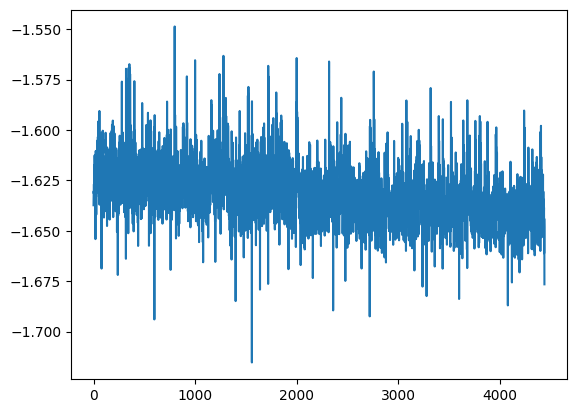

In [ ]:
plt.plot(lossi)

x_img.max()=tensor(3.2625, device='cuda:0'), x_img.min()=tensor(-3.5914, device='cuda:0')
x_ts=tensor([[0.]], device='cuda:0')
x_ts=tensor([[1.]], device='cuda:0')
x_ts=tensor([[2.]], device='cuda:0')
x_ts=tensor([[3.]], device='cuda:0')
x_ts=tensor([[4.]], device='cuda:0')
x_ts=tensor([[5.]], device='cuda:0')
x_ts=tensor([[6.]], device='cuda:0')
x_ts=tensor([[7.]], device='cuda:0')
x_ts=tensor([[8.]], device='cuda:0')
x_ts=tensor([[9.]], device='cuda:0')
x_ts=tensor([[10.]], device='cuda:0')
x_ts=tensor([[11.]], device='cuda:0')
x_ts=tensor([[12.]], device='cuda:0')
x_ts=tensor([[13.]], device='cuda:0')
x_ts=tensor([[14.]], device='cuda:0')
x_ts=tensor([[15.]], device='cuda:0')


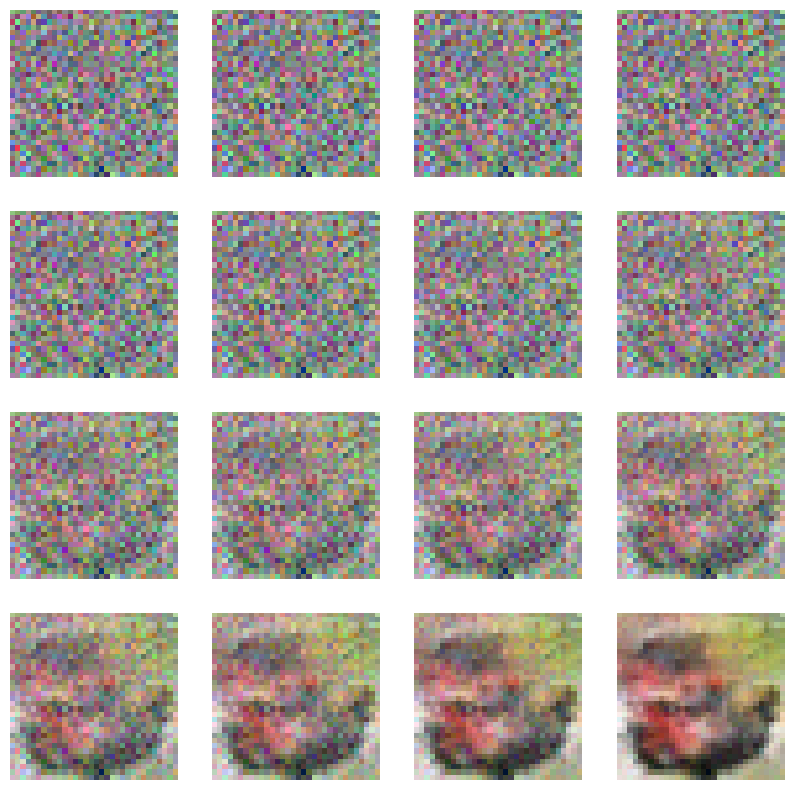

In [ ]:
def sample():
  plt.figure(figsize=(10, 10))

  # x_img = torch.normal(mean=torch.zeros(1, 3, 32, 32),
  #                      std=torch.ones(1, 3, 32, 32)).to(device)
  x_img = torch.randn(size=(1, 3, 32, 32), device=device)
  print(f'{x_img.max()=}, {x_img.min()=}')
  for i in range(16):
    plt.subplot(4, 4, i+1)
    # x_show = torch.clamp(x_img, min=-1.0, max=1.0)
    plt.imshow(cvtImg(x_img.detach())[0])
    plt.axis('off')

    # x_ts = torch.Tensor([time_bar[i+1]]).view(1, 1).to(device)
    x_ts = torch.Tensor([i]).view(1, 1).to(device)
    print(f'{x_ts=}')
    x_img = model(x_img, x_ts)


sample()


  0%|          | 0/16 [00:00<?, ?it/s]

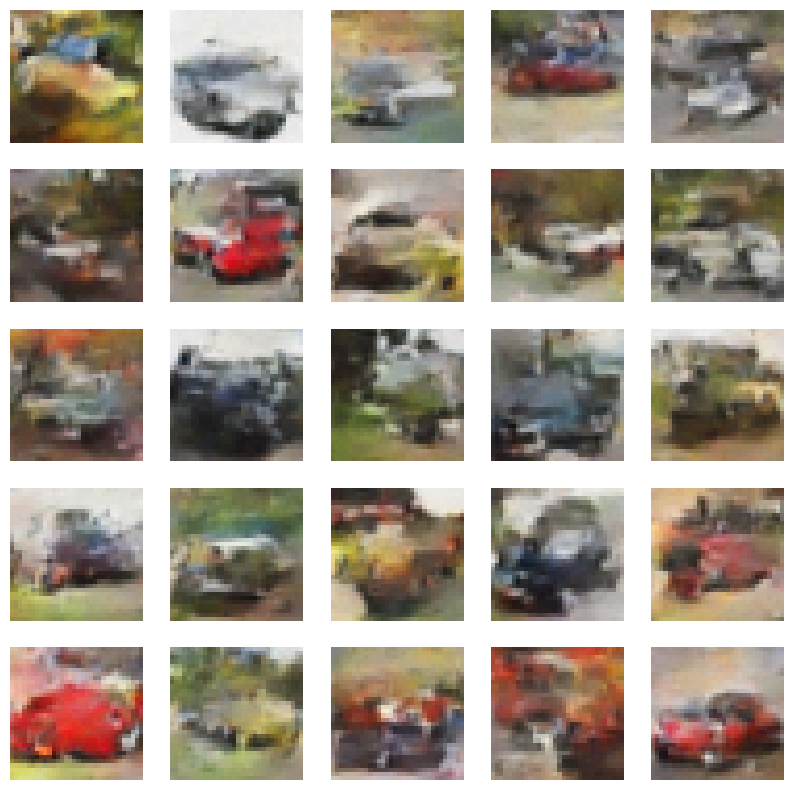

In [ ]:
def predict(x_idx=None):
    x = torch.randn(32, 3, IMG_SIZE, IMG_SIZE).to(device)
    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([32, 1], t, dtype=torch.float, device=device))

    show_examples(x.cpu())

predict()

In [ ]:
def predict_step():
    xs = []
    x = torch.randn(size=(8, 3, IMG_SIZE, IMG_SIZE), device=device)

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

# Author's training code

The author uses the tqdm well to print nice progress bars

In [ ]:
# def train_one(x_img):
#     x_ts = generate_ts(len(x_img))
#     x_a, x_b = forward_noise(x_img, x_ts)

#     x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
#     x_a = x_a.float().to(device)
#     x_b = x_b.float().to(device)

#     y_p = model(x_a, x_ts)
#     loss = torch.mean(torch.abs(y_p - x_b))
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # model.opt.zero_grad()
#     # loss.backward()
#     # model.opt.step()

#     return loss.item()

In [ ]:
# def train(R=50):
#     bar = trange(R)
#     total = len(trainloader)
#     for i in bar:
#         for j, (x_img, _) in enumerate(trainloader):
#             loss = train_one(x_img)
#             pg = (j / total) * 100
#             if j % 5 == 0:
#                 bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [ ]:
# # - 30%: 0.049 loss
# for _ in range(10):
#     train()
#     # reduce learning rate for next training
#     for pg in optimizer.param_groups:
#         pg['lr'] = max(0.000001, pg['lr'] * 0.9)

#     # show result
#     predict()
#     predict_step()
#     plt.show()